In [1]:
from ising.model import IsingModelND
import numpy as np
from ipywidgets import interact
from scipy import constants
from jax.config import config
import jax.numpy as jnp
import jax
from tqdm.auto import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from ising import primitives
import os
from uncertainties import unumpy as unp
from uncertainties import ufloat as uf

# CPU cores as separate devices
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={os.cpu_count()}'

config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

Doing 6400000 MCMC steps


  0%|          | 0/20 [00:00<?, ?it/s]

0: 0.50
1: 0.50
2: 0.50
3: 0.50
4: 0.50
5: 0.50
6: 0.50
7: 0.50
8: 0.50
9: 0.50
10: 0.50
11: 0.50
12: 0.50
13: 0.50
14: 0.50
15: 0.50
16: 0.50
17: 0.50
18: 0.50
19: 0.50
20: 0.50
21: 0.50
22: 0.49
23: 0.48
24: 0.45
25: 0.41
26: 0.35
27: 0.27
28: 0.19
29: 0.13
30: 0.12
31: 0.07


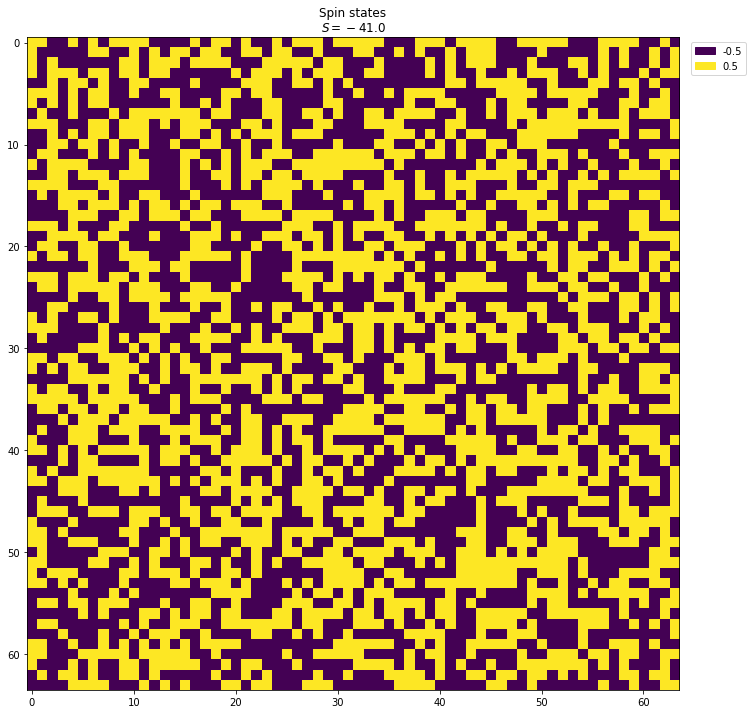

In [2]:
interaction_bilinear = 1.0
interaction_external_field = interaction_bilinear
nuclear_magnetic_moment = 1.0

temperatures = np.geomspace(0.02, 5, 2**5) / constants.Boltzmann * interaction_bilinear

model = IsingModelND(
    2,
    size=64,
    spin=1 / 2,
    interaction_bilinear=interaction_bilinear,
    interaction_external_field=interaction_external_field,
    nuclear_magnetic_moment=nuclear_magnetic_moment,
)
model.initial_state.plot()

steps_per_state = int(1e4)
num_states = 20
states = [model.initial_state.copy() for n in range(len(temperatures))]
all_states = [list(state.copy() for state in states)]
print(f"Doing {steps_per_state * num_states * len(temperatures)} MCMC steps")

for n in tqdm(range(num_states)):
    model.run_steps(states, steps_per_state, temperatures, bc_mode="periodic")
    all_states.append([state.copy() for state in states])

end_magnetisations = [model.get_magnetisation(state) for state in all_states[-1]]

for i, mag in enumerate(end_magnetisations):
    print(f"{i}: {mag:.2f}")


In [3]:
# temperature_n = 8
# @interact(value=0, min=0, max=len(all_states))
# def update(i=(0, len(all_states) - 1)):

#     all_states[i][temperature_n].plot()

In [4]:
# End states
@interact(value=0, min=0, max=len(temperatures))
def update(i=(0, len(temperatures) - 1)):

    all_states[-1][i].plot()

interactive(children=(IntSlider(value=15, description='i', max=31), Output()), _dom_classes=('widget-interact'…

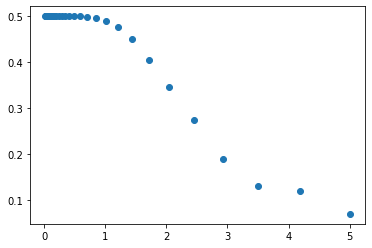

In [5]:
plt.figure()
x = np.array(temperatures * constants.Boltzmann / interaction_bilinear)
y = [model.get_magnetisation(state) for state in all_states[-1]]

plt.scatter(x, y)


In [6]:
states = all_states[-1]
energy_devs = []
for i in tqdm(range(500)):
    energy_devs.append([model.get_energy(state) for state in states])
    model.run_steps(states, 1, temperatures, bc_mode = "constant")


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 32)
(32,)


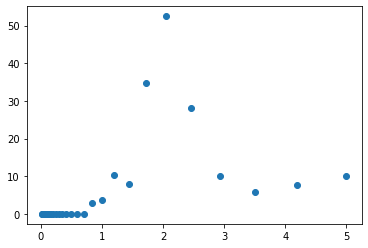

In [7]:
e_devs = np.array(energy_devs)
print(e_devs.shape)
e_std = e_devs.std(axis=0)
print(e_std.shape)

heat_caps = np.square(e_std / (constants.Boltzmann * temperatures))

plt.plot(x, heat_caps, "o")

32
32
1.7173253601682403
(8, 4, 64, 64)
(8, 4, 2500, 2)
(8, 4)
[[1.65809955e+03 1.26766460e-01]
 [1.65792735e+03 1.26687788e-01]
 [1.65775229e+03 1.26692431e-01]
 ...
 [1.65820777e+03 1.26730539e-01]
 [1.65815334e+03 1.26674791e-01]
 [1.65756328e+03 1.26652078e-01]]
(32, 2500, 2)
[0.0+/-0 0.0+/-0 0.0+/-0 0.0+/-0 0.0+/-0 0.0+/-0 0.0+/-0 0.0+/-0 0.0+/-0
 0.0+/-0 0.0+/-0 0.0+/-0 0.0+/-0 0.0+/-0 0.0+/-0 0.0+/-0 0.0+/-0 0.0+/-0
 0.0+/-0 0.09997999799959989+/-0.09997999799959989
 0.1731011265127989+/-0.1731011265127989
 0.26194472699407406+/-0.26194472699407406
 0.45906670539258226+/-0.45906670539258226
 0.7056883164683967+/-0.7056883164683967
 0.8629879257556273+/-0.8629879257556273
 1.051777619081144+/-1.051777619081144
 1.2421449834862275+/-1.2421449834862275
 1.3611362312421194+/-1.3611362312421194
 1.3861030841896285+/-1.3861030841896285
 1.4554458286037308+/-1.4554458286037308
 1.4305465249337401+/-1.4305465249337401
 1.518519015356739+/-1.518519015356739]


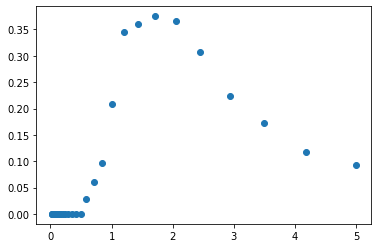

In [9]:
print(len(temperatures))
print(len(states))
i = 25
print(x[i])
a = model.get_equilibrium_energies_and_magnetisations(states, 2500, temperatures)




[[1.65809955e+03 1.26766460e-01]
 [1.65792735e+03 1.26687788e-01]
 [1.65775229e+03 1.26692431e-01]
 ...
 [1.65820777e+03 1.26730539e-01]
 [1.65815334e+03 1.26674791e-01]
 [1.65756328e+03 1.26652078e-01]]
(32, 2500, 2)


<ErrorbarContainer object of 3 artists>

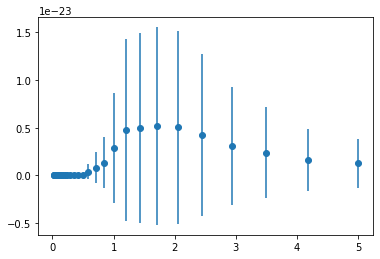

In [31]:
print(a.std(axis=0))
print(a.shape)

e_stds= a.std(axis=1)
e_stds.shape

stds_ = e_stds[:, 0].tolist()
stds = unp.uarray(stds_, stds_)
heat_caps = np.square(stds) / (constants.Boltzmann * np.square(temperatures))

plt.errorbar(x, unp.nominal_values(heat_caps), unp.std_devs(heat_caps), fmt="o")

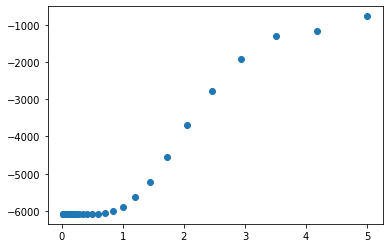

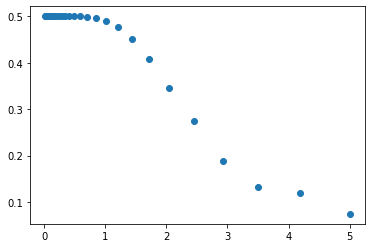

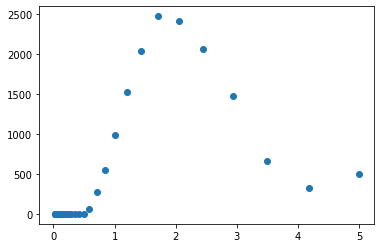

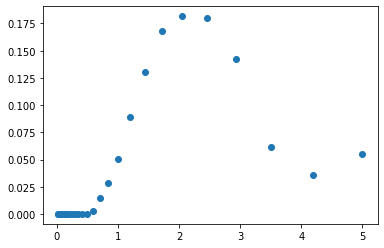

In [ ]:
energies = np.fromiter([model.get_energy(state) for state in states], float)
mags = np.fromiter([model.get_magnetisation(state) for state in states], float)

heat_caps = np.abs(np.gradient(energies, x))
susceptibilities = np.abs(np.gradient(mags, x))

plt.figure()
plt.plot(x, energies, "o")

plt.figure()
plt.plot(x, mags, "o")

plt.figure()
plt.plot(x, heat_caps, "o")

plt.figure()
plt.plot(x, susceptibilities, "o")

ValueError: x and y can be no greater than 2D, but have shapes (32,) and (32, 64, 64)

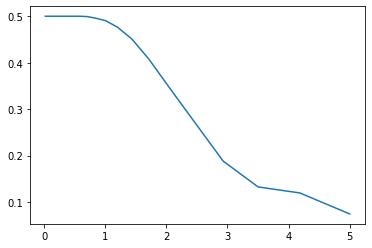

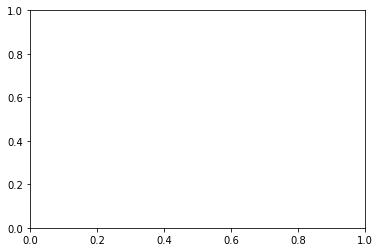

In [ ]:
from jax import grad, vmap

def get_mag(state):
    return state.sum() / state.size

dget_mag = vmap(grad(get_mag))

mags = np.array([get_mag(s.arr) for s in states])
dmags = dget_mag(np.array([s.arr for s in states]))
# dmags = np.gradient(mags, x)


plt.figure()
plt.plot(x, mags)
plt.figure()
plt.plot(x, dmags)